In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
from caltech256 import Caltech256
from copy import deepcopy
import numpy as np

import torchvision
import torchvision.transforms as transforms


In [2]:

example_transform = transforms.Compose(
    [
        transforms.Scale((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)
        
caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
caltech256_test = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=False)

train_data = DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)

test_data = DataLoader(
    dataset = caltech256_test,
    batch_size = 8,
    shuffle = True,
    num_workers = 4
)



In [3]:
len(test_data)

256

In [4]:
#import pretrained VGG 16 
import torchvision.models as models
#Define a Convolution Neural Network
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
vgg16 = models.vgg16(pretrained=True)#Define a Convolution Neural Network
for param in vgg16.parameters():   
    param.requires_grad = False

vgg16.classifier._modules['6'] = nn.Linear(4096, 256)
vgg16 = vgg16.cuda()

In [5]:
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(),lr = 0.001)

In [7]:
#http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
Train_acc = []
Test_acc = []
Train_loss = []
Test_loss = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    train_data = DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
    )

    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        train_loss+=loss.data[0]
    print "At epoch ",epoch+1
    print "Training loss is ",(train_loss/256)

    Train_loss.append(train_loss/256)    
    #Train
    correct = 0
    total = 0
    for data in train_data:
        images, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = vgg16(Variable(images.cuda()))
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    print('Accuracy of the network on the training images: %f %%' % (
        100.0 * correct / total))
    Train_acc.append(100.0 * correct / total)
    
    #Test
    correct = 0
    total = 0
    test_loss = 0.0
    for data in test_data:
        images, labels = data
        labels = labels.view(8)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = vgg16(Variable(images.cuda()))
        _,predicted = torch.max(outputs.data,1)
        loss = criterion(outputs,Variable(labels.cuda()))
        test_loss+=loss.data[0]
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    Test_loss.append(test_loss/256)
    print "Test loss is ",(test_loss/256)
    print('Accuracy of the network on the test images: %f %%' % (
        100.0 * correct / total))
    Test_acc.append(100.0 * correct / total)
print('Finished Training')

At epoch  1
Training loss is  2.06446039607
Accuracy of the network on the training images: 83.337402 %
Test loss is  1.32929419423
Accuracy of the network on the test images: 69.091797 %
At epoch  2
Training loss is  0.640396363975
Accuracy of the network on the training images: 90.722656 %
Test loss is  1.32038210542
Accuracy of the network on the test images: 69.677734 %
At epoch  3
Training loss is  0.367997811642
Accuracy of the network on the training images: 93.481445 %
Test loss is  1.38130154065
Accuracy of the network on the test images: 70.703125 %
At epoch  4
Training loss is  0.2328002922
Accuracy of the network on the training images: 95.190430 %
Test loss is  1.42121620174
Accuracy of the network on the test images: 70.312500 %
At epoch  5
Training loss is  0.17273260752
Accuracy of the network on the training images: 96.484375 %
Test loss is  1.4448599671
Accuracy of the network on the test images: 71.533203 %
At epoch  6
Training loss is  0.150063141919
Accuracy of the

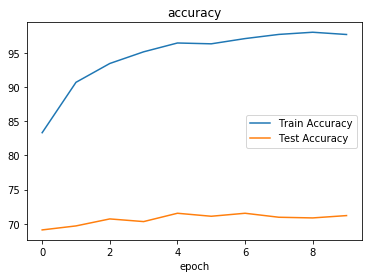

In [8]:
import matplotlib.pyplot as plt
plt.plot(Train_acc, label='Train Accuracy')
plt.plot(Test_acc,label='Test Accuracy')
plt.xlabel('epoch')
plt.title("accuracy")
plt.legend()
plt.show()

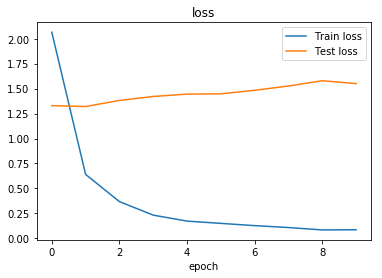

In [9]:
import matplotlib.pyplot as plt
plt.plot(Train_loss, label='Train loss')
plt.plot(Test_loss,label='Test loss')
plt.xlabel('epoch')
plt.title("loss")
plt.legend()
plt.show()

In [10]:
class Onelayer(nn.Module):
    def __init__(self):
        super(Onelayer, self).__init__()
        self.features = nn.Sequential(vgg16.features._modules['0'])
    def forward(self, x):
        x = self.features(x)
        return x
onelayer = Onelayer()
onelayer

Onelayer (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Feature Extraction

In [11]:
#use three conv blocks
#import pretrained VGG 16 
#Define a Convolution Neural Network
vgg16 = models.vgg16(pretrained=True)#Define a Convolution Neural Network
for param in vgg16.parameters():   
    param.requires_grad = False

threeconv = nn.Sequential(*list(vgg16.features.children())[:17]) 
threeconv.cuda()

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
)

In [12]:
# add fc layer
transfer_lr = torch.nn.Sequential(
                torch.nn.Linear(200704,1024),
                torch.nn.ReLU(),
                torch.nn.Linear(1024,256))
transfer_lr.cuda()

Sequential (
  (0): Linear (200704 -> 1024)
  (1): ReLU ()
  (2): Linear (1024 -> 256)
)

In [13]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transfer_lr.parameters(), lr=1e-3)

In [14]:
Train_acc = []
Test_acc = []
Train_loss = []
Test_loss = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    train_data = DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
    )

    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = threeconv(inputs)
        final_outputs = transfer_lr(outputs.view(-1,200704))
    
        loss = criterion(final_outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        train_loss += loss.data[0]
    print "At epoch ",epoch+1
    print "Training loss is ",(train_loss/256)
    Train_loss.append(train_loss/256)
    #Train
    correct = 0
    total = 0
    for data in train_data:
        images, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = threeconv(Variable(images.cuda()))
        final_outputs = transfer_lr(outputs.view(-1,200704))
        _,predicted = torch.max(final_outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of the network on the training images: %f %%' % (
        100.0 * correct / total))
    Train_acc.append(100.0 * correct / total)
    
    #Test
    correct = 0
    total = 0
    test_loss = 0.0
    for data in test_data:
        images, labels = data
        labels = labels.view(8)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = threeconv(Variable(images.cuda()))
        final_outputs = transfer_lr(outputs.view(-1,200704))
        _,predicted = torch.max(final_outputs.data,1)
        loss = criterion(final_outputs,Variable(labels.cuda()))
        test_loss += loss.data[0]
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of the network on the test images: %f %%' % (
        100.0 * correct / total))
    print "Test loss is ",(test_loss/256)
    Test_acc.append(100.0 * correct / total)
    Test_loss.append(test_loss/256)
print('Finished Training')

At epoch  1
Training loss is  5.35353818536
Accuracy of the network on the training images: 47.387695 %
Accuracy of the network on the test images: 10.009766 %
Test loss is  4.82482833974
At epoch  2
Training loss is  2.34442340583
Accuracy of the network on the training images: 97.509766 %
Accuracy of the network on the test images: 16.894531 %
Test loss is  4.3046548022
At epoch  3
Training loss is  0.115858497098
Accuracy of the network on the training images: 99.987793 %
Accuracy of the network on the test images: 25.341797 %
Test loss is  3.78908139188
At epoch  4
Training loss is  0.0167684670887
Accuracy of the network on the training images: 99.987793 %
Accuracy of the network on the test images: 27.050781 %
Test loss is  3.6572294631
At epoch  5
Training loss is  0.00894333189353
Accuracy of the network on the training images: 99.987793 %
Accuracy of the network on the test images: 28.125000 %
Test loss is  3.63221757673
At epoch  6
Training loss is  0.0104702117969
Accuracy o

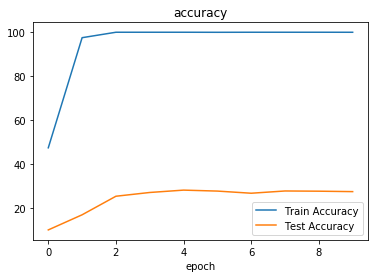

In [15]:
import matplotlib.pyplot as plt
plt.plot(Train_acc, label='Train Accuracy')
plt.plot(Test_acc,label='Test Accuracy')
plt.xlabel('epoch')
plt.title("accuracy")
plt.legend()
plt.show()

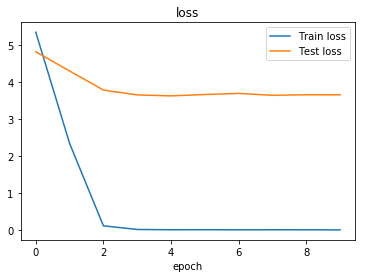

In [16]:
import matplotlib.pyplot as plt
plt.plot(Train_loss, label='Train loss')
plt.plot(Test_loss,label='Test loss')
plt.xlabel('epoch')
plt.title("loss")
plt.legend()
plt.show()

In [17]:
####fourblock
vgg16 = models.vgg16(pretrained=True)#Define a Convolution Neural Network
for param in vgg16.parameters():   
    param.requires_grad = False
fourconv = nn.Sequential(*list(vgg16.features.children())[:24]) 
fourconv.cuda()
transfer_lr = torch.nn.Sequential(
                torch.nn.Linear(14*14*512,1024),
                torch.nn.ReLU(),
                torch.nn.Linear(1024,256))
transfer_lr.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transfer_lr.parameters(), lr=1e-3, momentum=0.9)


In [18]:
Train_acc = []
Test_acc = []
Train_loss = []
Test_loss = []
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    train_data = DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
    )

    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = fourconv(inputs)
        final_outputs = transfer_lr(outputs.view(-1,14*14*512))
        loss = criterion(final_outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        train_loss += loss.data[0]
    print "At epoch ",epoch+1
    print "Training loss is ",(train_loss/256)
    Train_loss.append(train_loss/256)

    #Train
    correct = 0
    total = 0
    for data in train_data:
        images, labels = data
        labels = labels.view(32)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = fourconv(Variable(images.cuda()))
        final_outputs = transfer_lr(outputs.view(-1,14*14*512))
        _,predicted = torch.max(final_outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    print('Accuracy of the network on the training images: %f %%' % (
        100.0 * correct / total))
    Train_acc.append(100.0 * correct / total)
    
    #Test
    correct = 0
    total = 0
    test_loss = 0.0
    for data in test_data:
        images, labels = data
        labels = labels.view(8)
        labels = labels.add(-1)
        labels= labels.type(torch.LongTensor)
        outputs = fourconv(Variable(images.cuda()))
        final_outputs = transfer_lr(outputs.view(-1,14*14*512))
        loss = criterion(final_outputs,Variable(labels).cuda())
        _,predicted = torch.max(final_outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        test_loss += loss.data[0]

    print('Accuracy of the network on the test images: %f %%' % (
        100.0 * correct / total))
    print "Test loss is ",(test_loss/256)
    Test_acc.append(100.0 * correct / total)
    Test_loss.append(test_loss/256)
print('Finished Training')

At epoch  1
Training loss is  3.87660641316
Accuracy of the network on the training images: 92.883301 %
Accuracy of the network on the test images: 37.646484 %
Test loss is  2.88420059555
At epoch  2
Training loss is  0.189472048369
Accuracy of the network on the training images: 99.829102 %
Accuracy of the network on the test images: 45.996094 %
Test loss is  2.40476833633
At epoch  3
Training loss is  0.0160956440959
Accuracy of the network on the training images: 99.865723 %
Accuracy of the network on the test images: 51.220703 %
Test loss is  2.16163305053
At epoch  4
Training loss is  0.00900301057845
Accuracy of the network on the training images: 99.987793 %
Accuracy of the network on the test images: 52.392578 %
Test loss is  2.1030043792
At epoch  5
Training loss is  0.00650904659415
Accuracy of the network on the training images: 99.987793 %
Accuracy of the network on the test images: 52.685547 %
Test loss is  2.09109395114
At epoch  6
Training loss is  0.00352663139347
Accur

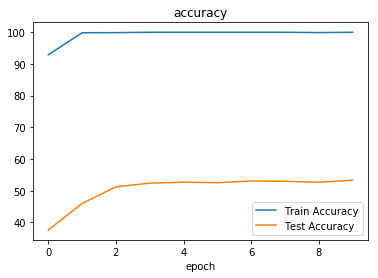

In [19]:
import matplotlib.pyplot as plt

plt.plot(Train_acc, label='Train Accuracy')
plt.plot(Test_acc,label='Test Accuracy')
plt.xlabel('epoch')
plt.title("accuracy")
plt.legend()
plt.show()

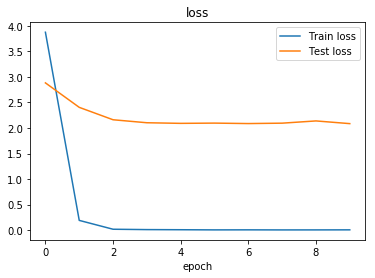

In [20]:
import matplotlib.pyplot as plt
plt.plot(Train_loss, label='Train loss')
plt.plot(Test_loss,label='Test loss')
plt.xlabel('epoch')
plt.title("loss")
plt.legend()
plt.show()